# Brain Tumor Classification

`Name: Gangula Karthik`<br>
`Admin No: 223715Y`

**Objective:** The objective of this project is to develop an accurate and efficient image classifier for brain tumor detection and classification using deep learning techniques on MRI images.

This project aims to use a comprehensive dataset of 7,023 human brain MRI images in order to build an image classifier capable of detecting and categorizing brain tumors into four classes:

- glioma
- meningioma
- pituitary
- no tumor (healthy)

By using both from-scratch approach and fine-tuning techniques, the aim will be to create a robust model that can assist medical professionals in early detection and classification of brain tumors. This work is crucial in the field of medical imaging, as accurate and timely diagnosis can significantly impact treatment decisions and patient outcomes.

## Table of Contents

1. Importing Packages

## Importing Packages

In [1]:
# Add imports here
import itertools
import pandas as pd
import cv2
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import os
import scipy.stats
import tensorflow as tf
import gc
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
!nvidia-smi

Fri Feb 21 14:36:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print(gpu)
    except RuntimeError as e:
        print(e)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Downloading Dataset

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


## Loading the Dataset

In [6]:
train_dir = os.path.join(path, "Training")
test_dir = os.path.join(path, "Testing")

In [7]:
def create_dataframe(directory):
    data = []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                data.append((img_path, label))
    return pd.DataFrame(data, columns=["file_path", "label"])

train_df = create_dataframe(train_dir)
test_df = create_dataframe(test_dir)

In [8]:
display("Train DataFrame:", train_df.head())
display("Test DataFrame:", test_df.head())

'Train DataFrame:'

file_path   label
0  /root/.cache/kagglehub/datasets/masoudnickparv...  glioma
1  /root/.cache/kagglehub/datasets/masoudnickparv...  glioma
2  /root/.cache/kagglehub/datasets/masoudnickparv...  glioma
3  /root/.cache/kagglehub/datasets/masoudnickparv...  glioma
4  /root/.cache/kagglehub/datasets/masoudnickparv...  glioma

'Test DataFrame:'

file_path   label
0  /root/.cache/kagglehub/datasets/masoudnickparv...  glioma
1  /root/.cache/kagglehub/datasets/masoudnickparv...  glioma
2  /root/.cache/kagglehub/datasets/masoudnickparv...  glioma
3  /root/.cache/kagglehub/datasets/masoudnickparv...  glioma
4  /root/.cache/kagglehub/datasets/masoudnickparv...  glioma

## Data Understanding

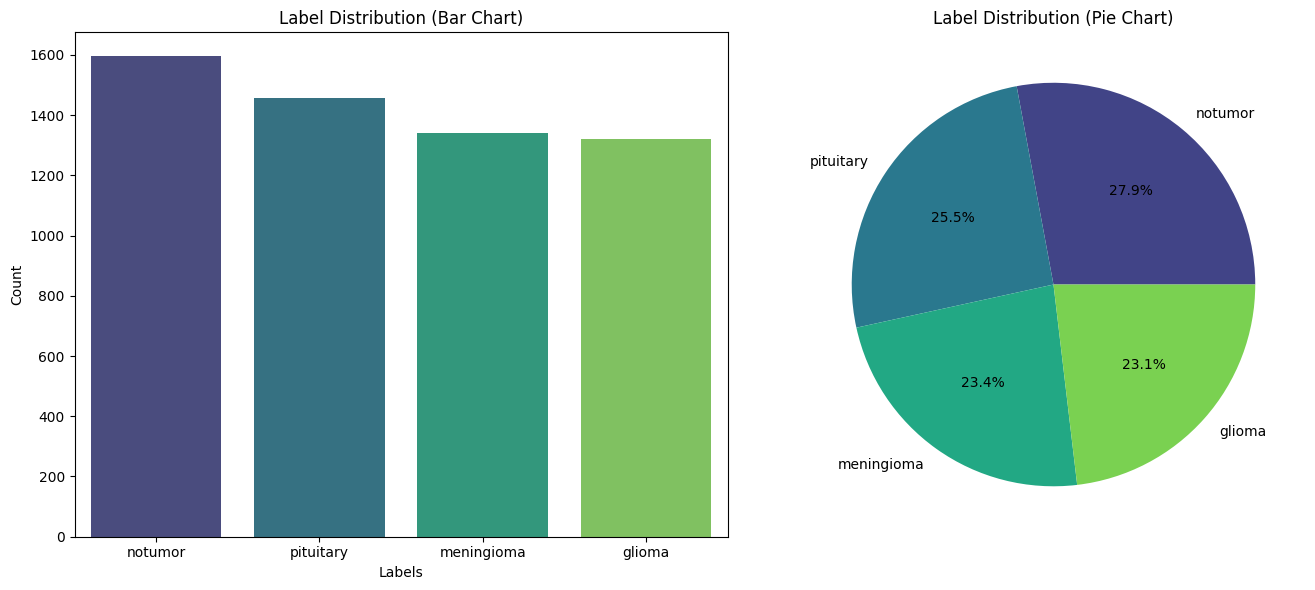

In [9]:
label_counts = train_df["label"].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x=label_counts.index, y=label_counts.values, ax=axes[0], palette="viridis")
axes[0].set_title("Label Distribution (Bar Chart)")
axes[0].set_xlabel("Labels")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis="x")

axes[1].pie(label_counts, labels=label_counts.index, autopct="%1.1f%%", colors=sns.color_palette("viridis", len(label_counts)))
axes[1].set_title("Label Distribution (Pie Chart)")

plt.tight_layout()
plt.show()

In [10]:
def get_image_size(image_path):
    img = cv2.imread(image_path)
    if img is not None:
        return img.shape[1], img.shape[0]
    return None, None

train_df["width"], train_df["height"] = zip(*train_df["file_path"].apply(get_image_size))

train_df["aspect_ratio"] = train_df["width"] / train_df["height"]

train_df[["width", "height", "aspect_ratio"]].describe()

width       height  aspect_ratio
count  5712.000000  5712.000000   5712.000000
mean    451.563200   453.883754      0.994201
std     131.004291   124.779164      0.109435
min     150.000000   168.000000      0.644809
25%     441.000000   442.000000      1.000000
50%     512.000000   512.000000      1.000000
75%     512.000000   512.000000      1.000000
max    1920.000000  1446.000000      1.785714

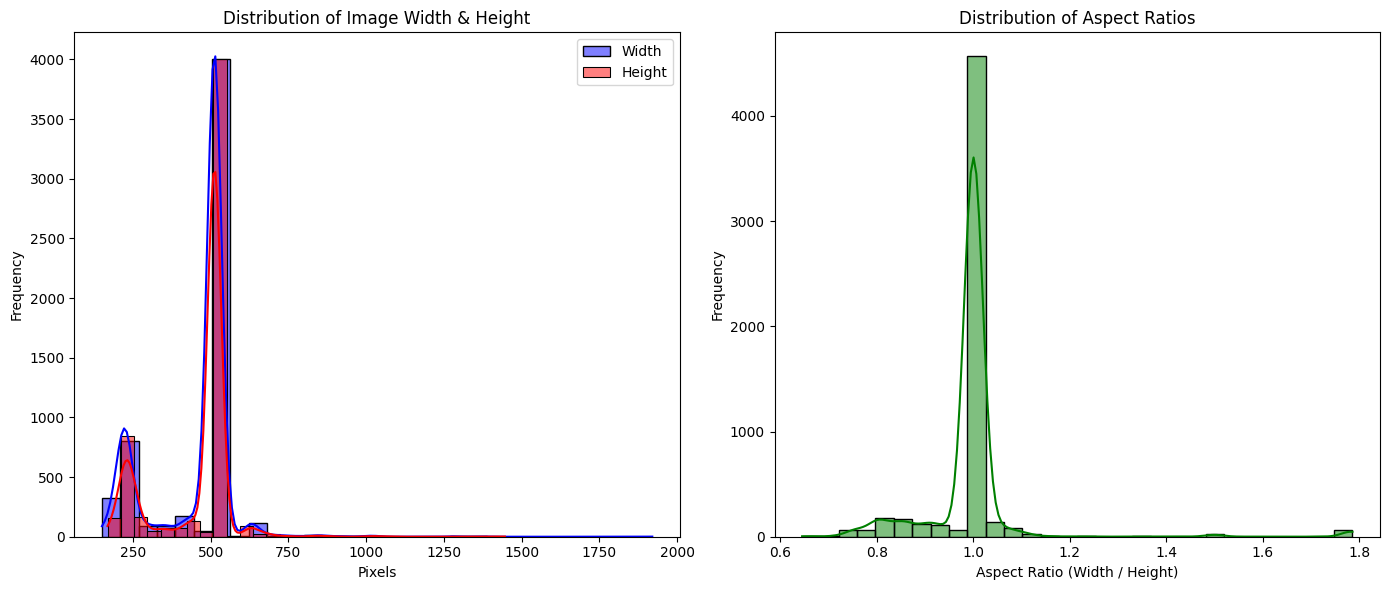

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# histogram of the image sizes
sns.histplot(train_df["width"], bins=30, kde=True, ax=axes[0], color="blue", label="Width")
sns.histplot(train_df["height"], bins=30, kde=True, ax=axes[0], color="red", label="Height")
axes[0].set_title("Distribution of Image Width & Height")
axes[0].set_xlabel("Pixels")
axes[0].set_ylabel("Frequency")
axes[0].legend()

# histogram of the aspect ratio
sns.histplot(train_df["aspect_ratio"], bins=30, kde=True, ax=axes[1], color="green")
axes[1].set_title("Distribution of Aspect Ratios")
axes[1].set_xlabel("Aspect Ratio (Width / Height)")
axes[1].set_ylabel("Frequency")

# Show plots
plt.tight_layout()
plt.show()

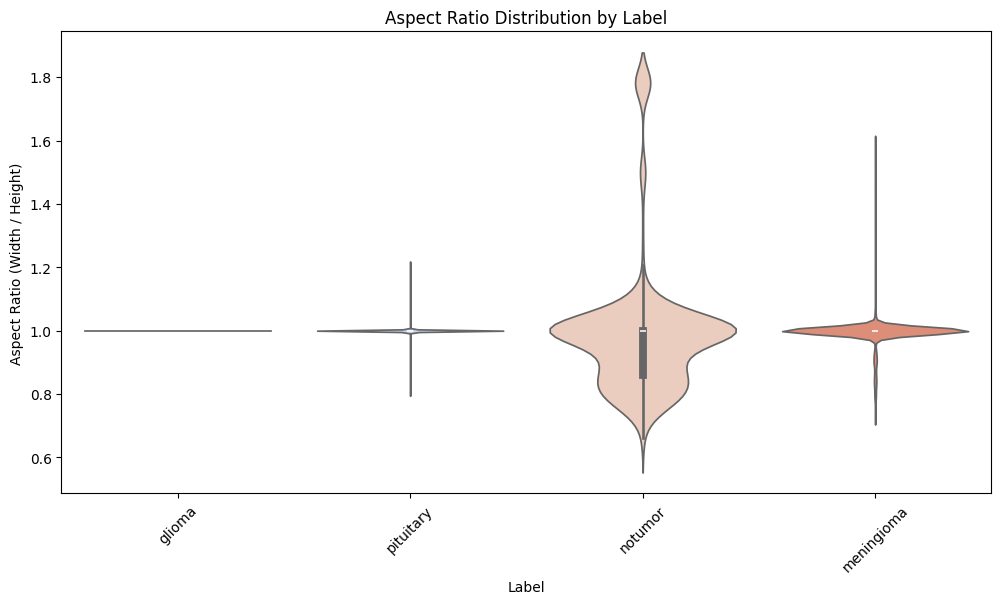

In [12]:
plt.figure(figsize=(12, 6))

sns.violinplot(x=train_df["label"], y=train_df["aspect_ratio"], palette="coolwarm")

plt.title("Aspect Ratio Distribution by Label")
plt.xlabel("Label")
plt.ylabel("Aspect Ratio (Width / Height)")
plt.xticks(rotation=45)

plt.show()

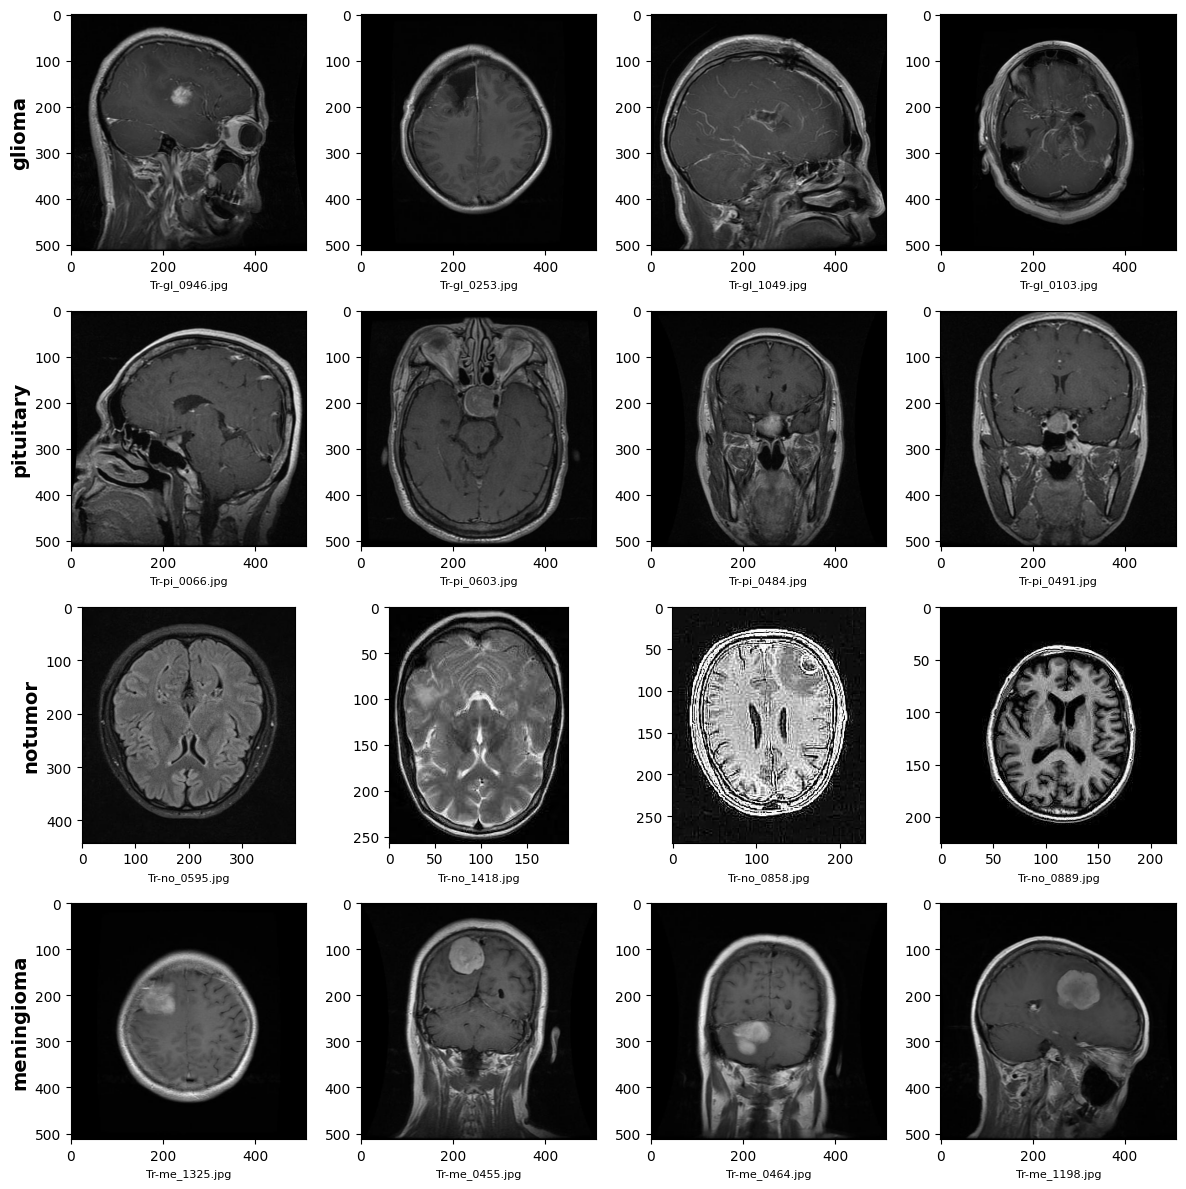

In [13]:
selected_labels = train_df["label"].unique()[:4]
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for row, label in enumerate(selected_labels):
    sample_paths = random.sample(train_df[train_df["label"] == label]["file_path"].tolist(), 4)

    for col, sample_path in enumerate(sample_paths):
        img = cv2.imread(sample_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ax = axes[row, col]
        ax.imshow(img)

        if col == 0:
            ax.set_ylabel(label, fontsize=14, fontweight="bold")

        img_name = os.path.basename(sample_path)
        ax.set_xlabel(img_name, fontsize=8, color="black")

plt.tight_layout()
plt.show()

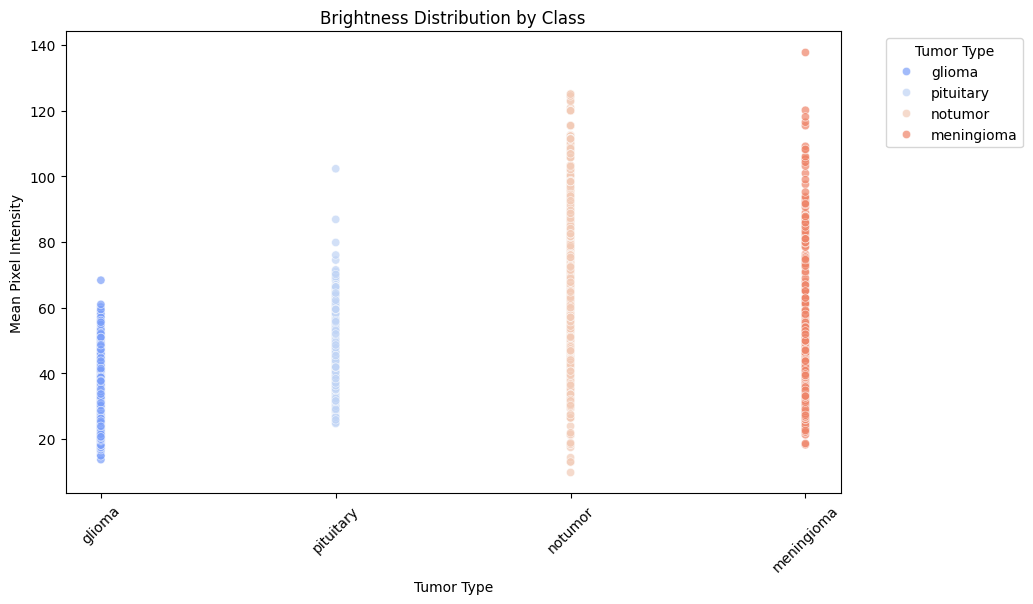

In [14]:
def compute_brightness(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return np.mean(img) if img is not None else None

train_df["brightness"] = train_df["file_path"].apply(compute_brightness)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_df["label"], y=train_df["brightness"], alpha=0.7, hue=train_df["label"], palette="coolwarm")
plt.title("Brightness Distribution by Class")
plt.xlabel("Tumor Type")
plt.ylabel("Mean Pixel Intensity")
plt.xticks(rotation=45)
plt.legend(title="Tumor Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

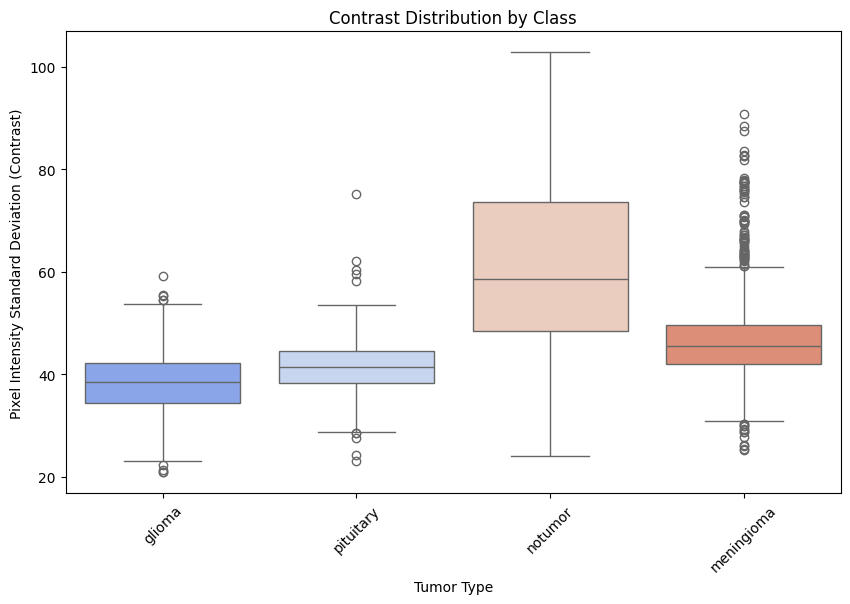

In [15]:
def compute_contrast(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return np.std(img) if img is not None else None

train_df["contrast"] = train_df["file_path"].apply(compute_contrast)

plt.figure(figsize=(10, 6))
sns.boxplot(x=train_df["label"], y=train_df["contrast"], palette="coolwarm")

plt.title("Contrast Distribution by Class")
plt.xlabel("Tumor Type")
plt.ylabel("Pixel Intensity Standard Deviation (Contrast)")
plt.xticks(rotation=45)
plt.show()

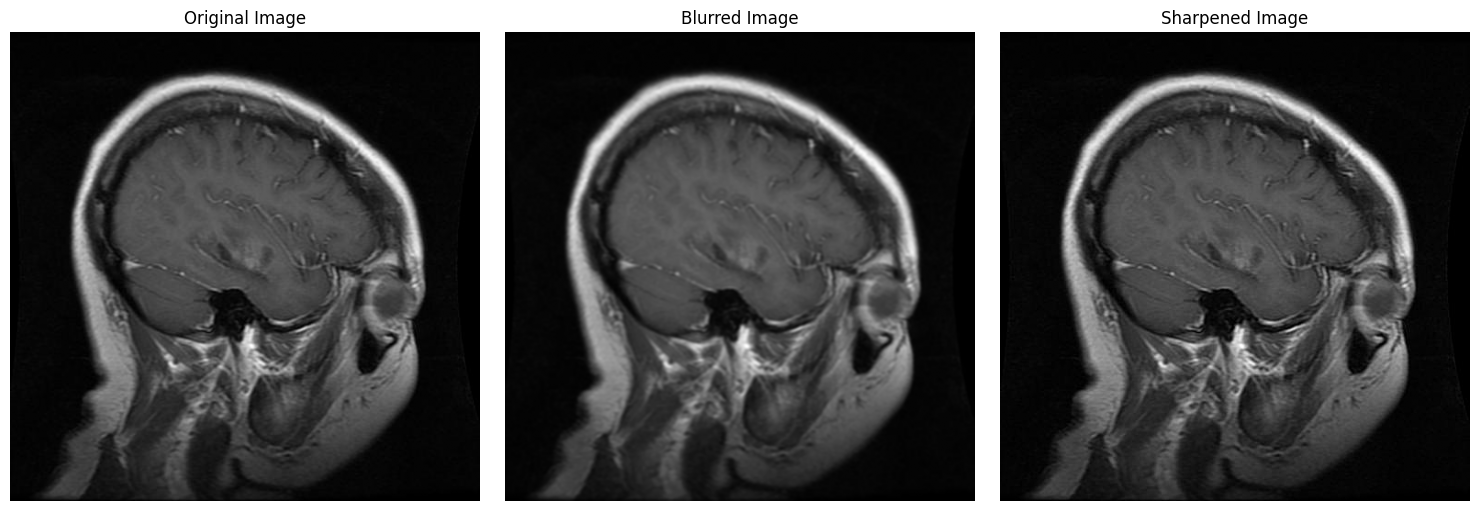

In [16]:
# image processing techniques

image_path = train_df.iloc[1, 0]
img = cv2.imread(image_path)

# Convert to grayscale for easier processing
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur
blurred = cv2.GaussianBlur(img_gray, (5, 5), 0)

# Subtract the blurred image from the original (sharpening)
sharpened = cv2.addWeighted(img_gray, 1.5, blurred, -0.5, 0)

# Plot the results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img_gray, cmap='gray')
axes[0].set_title("Original Image")
axes[1].imshow(blurred, cmap='gray')
axes[1].set_title("Blurred Image")
axes[2].imshow(sharpened, cmap='gray')
axes[2].set_title("Sharpened Image")

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

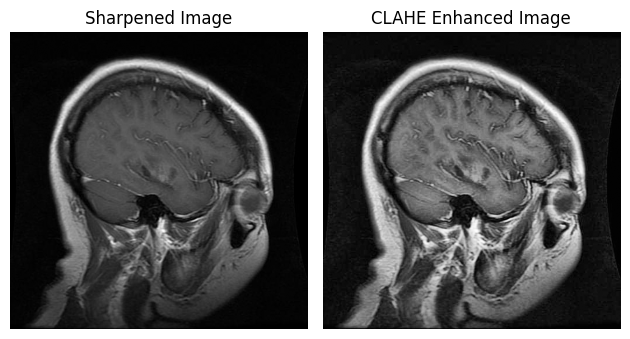

In [17]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
img_clahe = clahe.apply(sharpened)

# Plot the results
plt.subplot(1, 2, 1)
plt.imshow(sharpened, cmap='gray')
plt.title("Sharpened Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_clahe, cmap='gray')
plt.title("CLAHE Enhanced Image")
plt.axis('off')

plt.tight_layout()
plt.show()

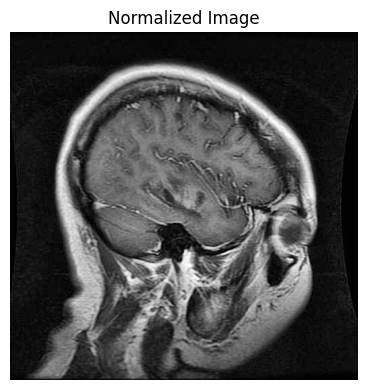

In [18]:
def z_score_normalization(mri_image):
    return (mri_image - np.mean(mri_image)) / np.std(mri_image)


normalized_img = z_score_normalization(img_clahe)

plt.figure(figsize=(12, 4))
plt.imshow(normalized_img, cmap='gray')
plt.title("Normalized Image")
plt.axis('off')

plt.tight_layout()
plt.show()

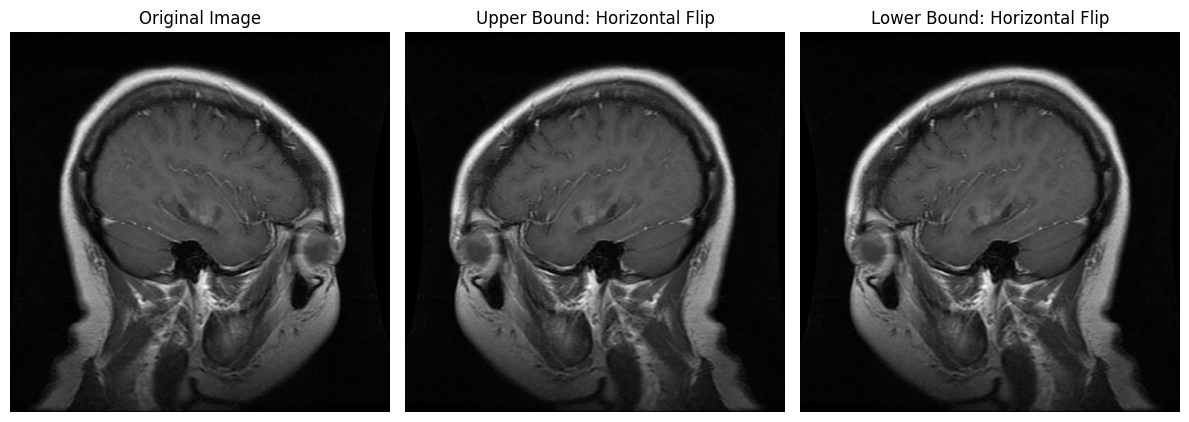

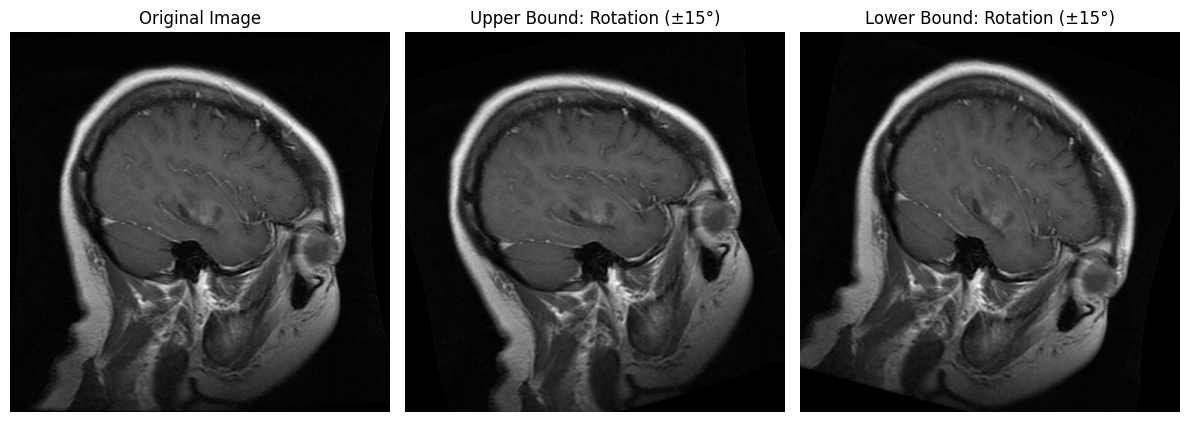

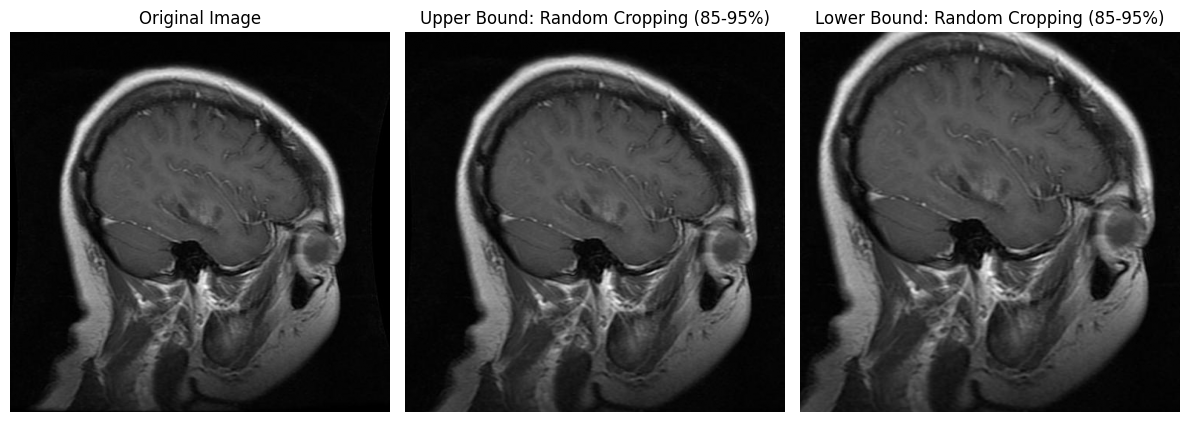

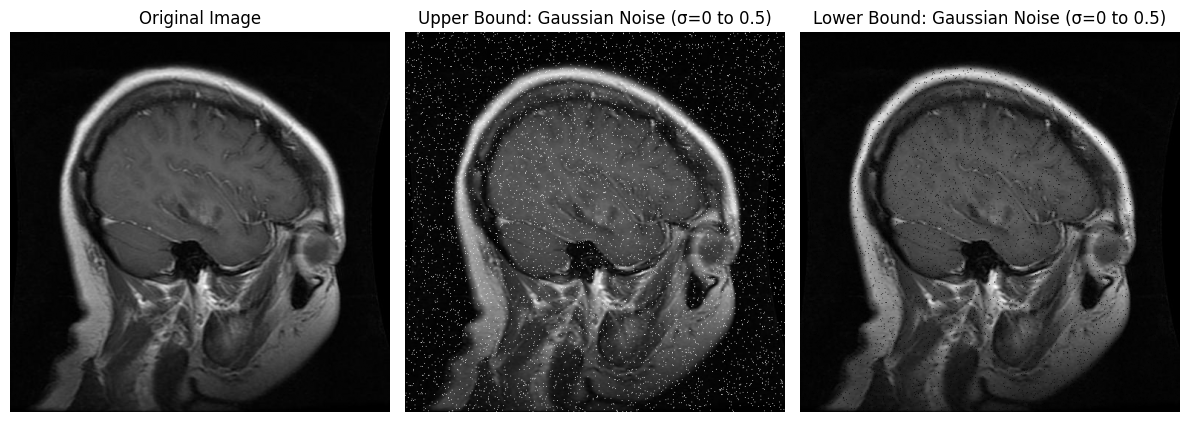

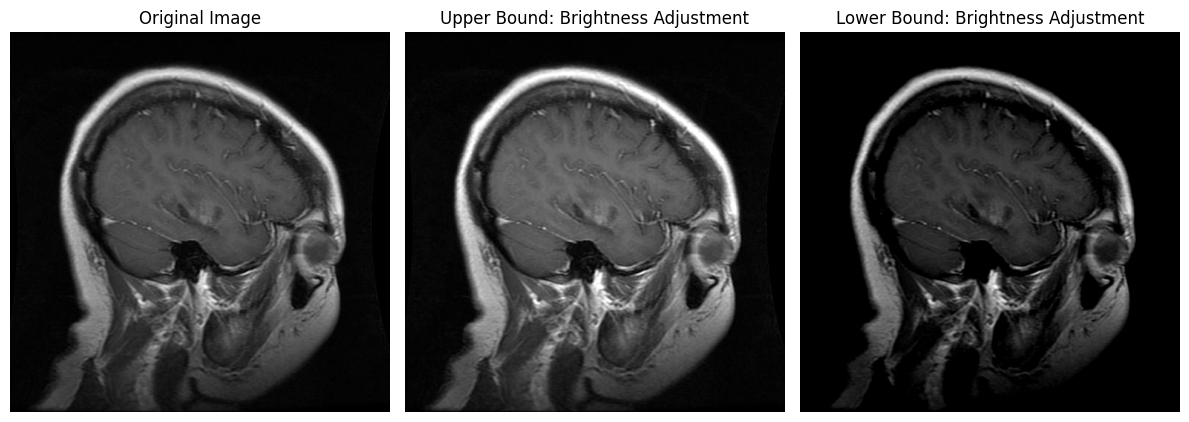

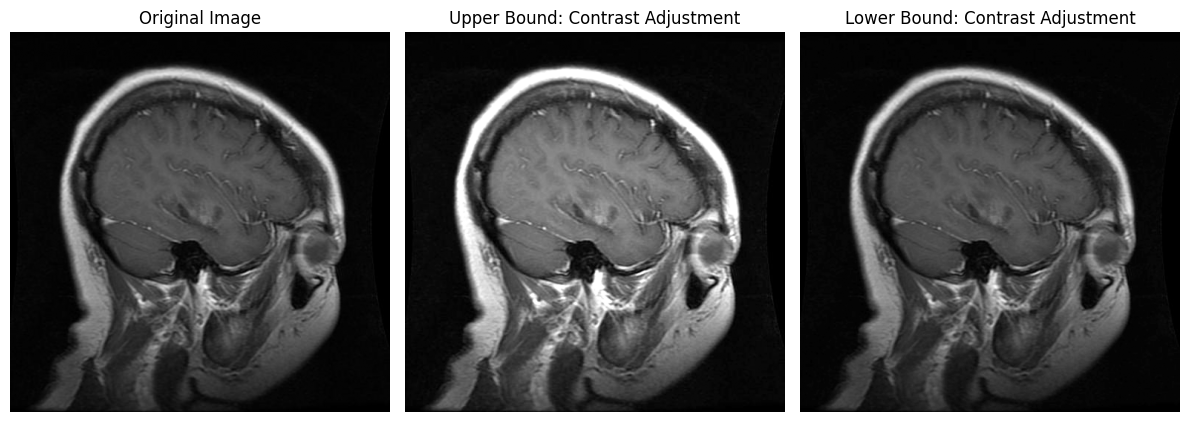

In [19]:
# Load MRI image
image_path = train_df.iloc[1, 0]
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Function to visualize transformations
def visualize_transforms(original, upper, lower, title):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(original, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(upper, cmap='gray')
    plt.title(f"Upper Bound: {title}")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(lower, cmap='gray')
    plt.title(f"Lower Bound: {title}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Apply transformations

# 1️⃣ Horizontal Flip
flipped = cv2.flip(img, 1)

# 2️⃣ Rotation (±15 degrees)
angle = 15
(h, w) = img.shape
center = (w // 2, h // 2)
M_rot_upper = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated_upper = cv2.warpAffine(img, M_rot_upper, (w, h))

M_rot_lower = cv2.getRotationMatrix2D(center, -angle, 1.0)
rotated_lower = cv2.warpAffine(img, M_rot_lower, (w, h))

# 3️⃣ Random Cropping (85-95% ROI)
crop_size_upper = int(0.95 * img.shape[0])
crop_size_lower = int(0.85 * img.shape[0])
crop_x_upper = np.random.randint(0, img.shape[1] - crop_size_upper)
crop_y_upper = np.random.randint(0, img.shape[0] - crop_size_upper)
cropped_upper = img[crop_y_upper:crop_y_upper+crop_size_upper, crop_x_upper:crop_x_upper+crop_size_upper]

crop_x_lower = np.random.randint(0, img.shape[1] - crop_size_lower)
crop_y_lower = np.random.randint(0, img.shape[0] - crop_size_lower)
cropped_lower = img[crop_y_lower:crop_y_lower+crop_size_lower, crop_x_lower:crop_x_lower+crop_size_lower]

# 4️⃣ Gaussian Noise (σ=0.05)
noise = np.random.normal(0, 0.5, img.shape).astype(np.uint8)
gaussian_noisy_upper = cv2.add(img, noise)
gaussian_noisy_lower = cv2.subtract(img, noise)

# 5️⃣ Brightness Adjustment
bright_img_upper = cv2.add(img, 40)  # Brightness increase
bright_img_lower = cv2.subtract(img, 40)  # Brightness decrease

# 6️⃣ Contrast Adjustment
contrast_img_upper = cv2.convertScaleAbs(img, alpha=1.5, beta=0)  # Increase contrast
contrast_img_lower = cv2.convertScaleAbs(img, alpha=0.5, beta=0)  # Decrease contrast

# Visualize the transformations
visualize_transforms(img, flipped, flipped, "Horizontal Flip")
visualize_transforms(img, rotated_upper, rotated_lower, "Rotation (±15°)")
visualize_transforms(img, cropped_upper, cropped_lower, "Random Cropping (85-95%)")
visualize_transforms(img, gaussian_noisy_upper, gaussian_noisy_lower, "Gaussian Noise (σ=0 to 0.5)")
visualize_transforms(img, bright_img_upper, bright_img_lower, "Brightness Adjustment")
visualize_transforms(img, contrast_img_upper, contrast_img_lower, "Contrast Adjustment")


## Data Preparation

In [20]:
def preprocess_image(image_path):
    """Load and resize image to 256x256 using TensorFlow."""
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [128, 128])
    img = tf.image.per_image_standardization(img)
    return img

def process_tf_image(image_path, label, num_classes):
    """Load and preprocess an image while converting label to one-hot."""
    image = preprocess_image(image_path)
    label = tf.one_hot(label, depth=num_classes, dtype=tf.float32)
    return image, label

def load_and_preprocess_from_df(df, num_classes, batch_size=32):
    """Create a TensorFlow dataset from a DataFrame."""
    file_paths = df['file_path'].values
    labels = df['label'].values

    unique_labels = sorted(df['label'].unique())
    label_to_index = {label: i for i, label in enumerate(unique_labels)}
    int_labels = np.array([label_to_index[label] for label in labels], dtype=np.int32)

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, int_labels))
    dataset = dataset.map(lambda x, y: process_tf_image(x, y, num_classes), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(len(train_df)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset, label_to_index

In [21]:
train_dataset, _ = load_and_preprocess_from_df(train_df, 4)
train_dataset = train_dataset.shuffle(buffer_size=500).prefetch(tf.data.AUTOTUNE)

In [22]:
AUTOTUNE = tf.data.AUTOTUNE

val_size = int(0.2 * len(train_dataset))

train_dataset = train_dataset.skip(val_size)
val_dataset = train_dataset.take(val_size)

train_dataset = train_dataset.cache().prefetch(AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(AUTOTUNE)

## Modelling (Training CNN model from scratch)

In [23]:
def build_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # ✅ CNN Feature Extraction with Batch Normalization
    x = layers.Conv2D(32, (3, 3), activation=None, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model


# Model compilation
model = build_model(input_shape=(128, 128, 3))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 4,289,604 (16.36 MB)

 Trainable params: 4,288,900 (16.36 MB)

 Non-trainable params: 704 (2.75 KB)

In [39]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [40]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_dataset,
    epochs=25,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 31s 118ms/step - accuracy: 0.7323 - loss: 0.6806 - val_accuracy: 0.2714 - val_loss: 2.2745
Epoch 2/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9103 - loss: 0.2554 - val_accuracy: 0.3821 - val_loss: 1.3709
Epoch 3/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - accuracy: 0.9470 - loss: 0.1581 - val_accuracy: 0.5697 - val_loss: 0.8665
Epoch 4/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - accuracy: 0.9716 - loss: 0.1031 - val_accuracy: 0.9821 - val_loss: 0.0977
Epoch 5/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.9854 - loss: 0.0672 - val_accuracy: 0.9710 - val_loss: 0.0827
Epoch 6/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.9950 - loss: 0.0389 - val_accuracy: 0.9982 - val_loss: 0.0202
Epoch 7/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 19s 91ms/step - accuracy: 0.9952 - loss: 0.0305 - val_accuracy: 0.9991 - val_loss: 0.0224
Epoch 8/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9977 - loss: 0.0249 -

In [33]:
def plot_training_curves(history):
    train_loss = history.history['loss']
    val_loss = history.history.get('val_loss')
    train_acc = history.history['accuracy']
    val_acc = history.history.get('val_accuracy')
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()

    # Plot Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
    if val_acc:
        plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()

    plt.show()

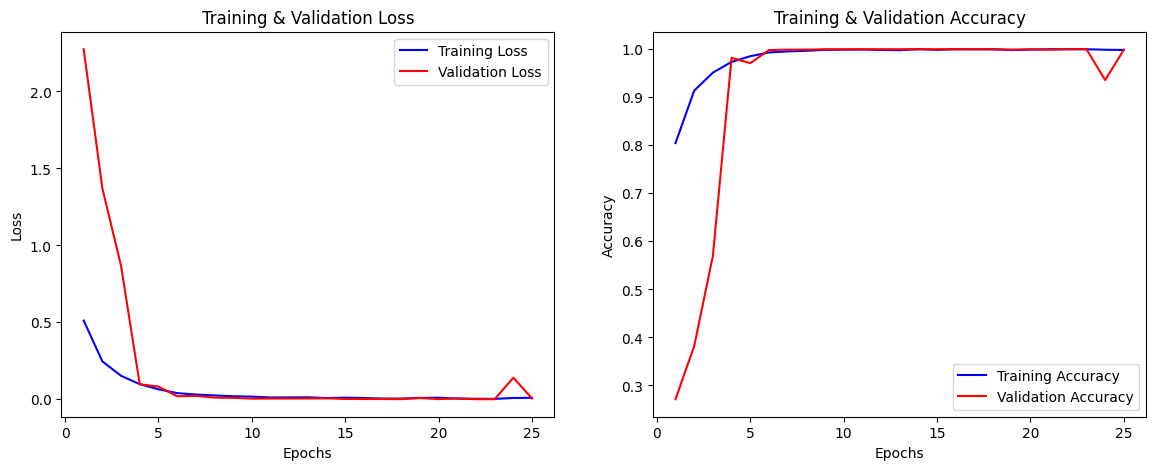

In [42]:
plot_training_curves(history)
tf.keras.backend.clear_session()
gc.collect()

### Data Augmentation

From the above results it can be seen that the model is clearly overfitting to the given data. How we can tell is that there is a sudden 20% increase in the accuracy in only one epoch and also the validation accuracy reaches 100% very early on in the training cycle.

One way to combat this issue is to have data augmentation, this will help the model to generalize better to the data.

In [29]:
# !pip install tf-models-official

In [25]:
# Model compilation
model = build_model(input_shape=(128, 128, 3))

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [26]:
import tensorflow_models as tfm

def augment_image(image):
    """Apply random brightness, contrast, flip, rotation, cropping, and noise using TensorFlow ops."""

    # Random brightness adjustment (scale factor between 0.8 and 1.2)
    brightness_factor = random.uniform(0.8, 1.2)
    image = tf.image.adjust_brightness(image, delta=brightness_factor - 1.0)

    # Random contrast adjustment (scale factor between 0.8 and 1.2)
    contrast_factor = random.uniform(0.8, 1.2)
    image = tf.image.adjust_contrast(image, contrast_factor)

    # Random horizontal flip (50% chance)
    image = tf.image.random_flip_left_right(image)

    # Random rotation (-15 to 15 degrees)
    angle = random.uniform(-15, 15)
    image = tfm.vision.augment.rotate(image, angle)

    # Random cropping (85% to 95% of original size)
    crop_ratio = random.uniform(0.85, 0.95)
    image = tf.image.resize_with_crop_or_pad(image, int(image.shape[0]*crop_ratio), int(image.shape[1]*crop_ratio))

    # Resize back to original dimensions
    image = tf.image.resize(image, (128, 128))

    # Apply random Gaussian noise (50% chance)
    if random.random() > 0.5:
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=10.0)
        image = image + noise
        image = tf.clip_by_value(image, 0.0, 255.0)

    # Normalize to range [0, 1]
    image = tf.cast(image, tf.float32) / 255.0

    return image

In [27]:
tf.experimental.numpy.experimental_enable_numpy_behavior()

def preprocess_image(image_path):
    """Load and resize image to 256x256 using TensorFlow."""
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [128, 128])
    img = tf.image.per_image_standardization(img)
    return img

# Processing function
def process_tf_image(image_path, label, num_classes, augment_fn=None):
    """Load, preprocess, and augment image while converting label to one-hot."""
    image = preprocess_image(image_path)

    if augment_fn:  # Apply augmentation if provided
        image = augment_fn(image)

    label = tf.one_hot(label, depth=num_classes, dtype=tf.float32)
    return image, label

# Function to create TensorFlow dataset
def load_and_preprocess_from_df(df, num_classes, batch_size=32, augment_fn=None):
    """Create a TensorFlow dataset from a DataFrame."""
    file_paths = df['file_path'].values
    labels = df['label'].values

    unique_labels = sorted(df['label'].unique())
    label_to_index = {label: i for i, label in enumerate(unique_labels)}
    int_labels = np.array([label_to_index[label] for label in labels], dtype=np.int32)

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, int_labels))
    dataset = dataset.map(lambda x, y: process_tf_image(x, y, num_classes, augment_fn), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(len(df)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset, label_to_index

In [28]:
# Assuming you have a DataFrame called train_df
train_dataset, label_map = load_and_preprocess_from_df(train_df, num_classes=4, batch_size=32, augment_fn=augment_image)
# Split into training and validation sets
AUTOTUNE = tf.data.AUTOTUNE
val_size = int(0.2 * len(train_dataset))  # 20% validation size

# Shuffle and split the dataset
train_dataset = train_dataset.shuffle(buffer_size=100).skip(val_size).cache().prefetch(AUTOTUNE)
val_dataset = train_dataset.take(val_size).cache().prefetch(AUTOTUNE)

len(train_dataset), len(val_dataset)

(144, 35)

In [29]:
history = model.fit(
    train_dataset,
    epochs=25,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - accuracy: 0.6979 - loss: 0.7575 - val_accuracy: 0.2277 - val_loss: 2.6347
Epoch 2/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9161 - loss: 0.2678 - val_accuracy: 0.2277 - val_loss: 3.4158
Epoch 3/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9646 - loss: 0.1482 - val_accuracy: 0.2277 - val_loss: 3.7725
Epoch 4/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9892 - loss: 0.0786 - val_accuracy: 0.2277 - val_loss: 3.1689
Epoch 5/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9965 - loss: 0.0449 - val_accuracy: 0.5929 - val_loss: 0.8511
Epoch 6/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9985 - loss: 0.0324 - val_accuracy: 0.8670 - val_loss: 0.2986
Epoch 7/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9986 - loss: 0.0254 - val_accuracy: 0.9920 - val_loss: 0.0400
Epoch 8/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9993 - loss: 0.0183 - val_acc

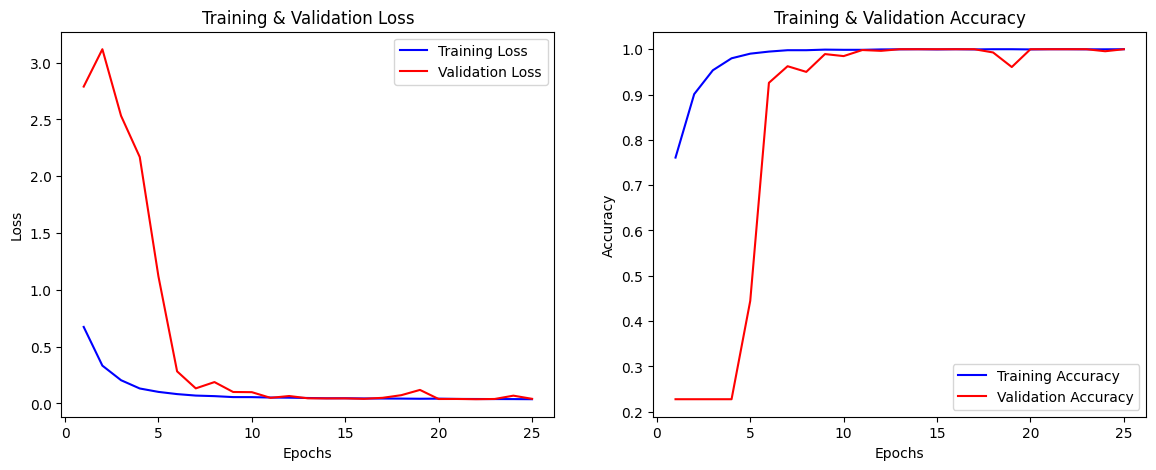

In [49]:
%matplotlib inline

plot_training_curves(history)

In [51]:
from tensorflow.keras import layers, regularizers

def build_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # ✅ CNN Feature Extraction with Batch Normalization, L2 Regularization, and Dropout
    x = layers.Conv2D(32, (3, 3), activation=None, padding='same',
                      kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation=None, padding='same',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation=None, padding='same',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)

    # Dense layer with L2 Regularization and Dropout
    x = layers.Dense(128, activation=None,
                     kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.4)(x)

    # Output layer with softmax activation
    outputs = layers.Dense(4, activation='softmax')(x)

    # Define the model
    model = tf.keras.Model(inputs, outputs)
    return model

In [52]:
# Model compilation
model = build_model(input_shape=(128, 128, 3))

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.1),
    metrics=['accuracy']
)

In [53]:
history = model.fit(
    train_dataset,
    epochs=25,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.6868 - loss: 1.0466 - val_accuracy: 0.2277 - val_loss: 2.6392
Epoch 2/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8877 - loss: 0.6651 - val_accuracy: 0.2277 - val_loss: 3.0421
Epoch 3/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9376 - loss: 0.5718 - val_accuracy: 0.2277 - val_loss: 2.6697
Epoch 4/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9635 - loss: 0.5172 - val_accuracy: 0.2321 - val_loss: 1.6437
Epoch 5/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9825 - loss: 0.4896 - val_accuracy: 0.8196 - val_loss: 0.7364
Epoch 6/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9915 - loss: 0.4773 - val_accuracy: 0.9866 - val_loss: 0.4798
Epoch 7/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9954 - loss: 0.4647 - val_accuracy: 0.9937 - val_loss: 0.4725
Epoch 8/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9951 - loss: 0.4572 - val_acc

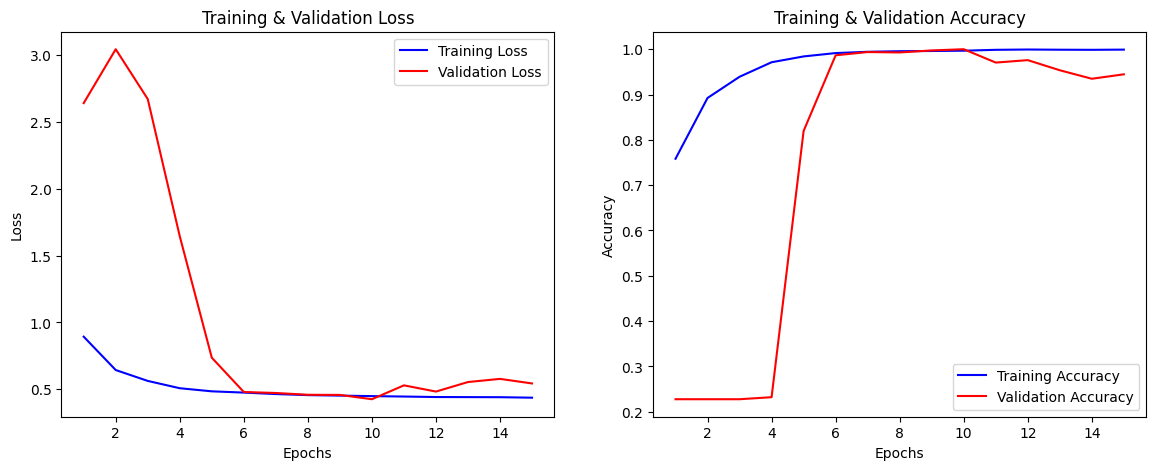

In [55]:
%matplotlib inline

plot_training_curves(history)

## Modelling (Transfer Learning on EfficientNetB0)